# Bioacoustic analysis of DAS-recorded data

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/gist/leabouffaut/e66b5a741493c4bd13aa07f39586ec4b/das4whales_examplenotebook.ipynb)

Author: Léa Bouffaut, Ph.D.
K. Lisa Yang Center for Conservation Bioacoustics, Cornell Lab of Ornithology, Cornell University. Ithaca (NY), USA

[Contact](mailto:lb736@cornell.edu) | [Webpage](https://www.birds.cornell.edu/ccb/lea-bouffaut/) | [Twitter](https://twitter.com/LeaBouffaut)

## Background
Distributed acoustic sensing or DAS, offers exciting new opportunities to eavesdrop on whales by converting existing fiber optic cables into dense listening arrays of strain sensors. It exploits the physics of Raileigh backscattering following the introduction of a interrogating pulse in the fiber, converting time-delays (or phase changes) of the backscattered pulses into strain measurements, analogus to acoustic pressure. DAS is also known as  Distributed Fiber Optic Sensing (DFOS), coherent backscattering, phase Optical Time Domain Reflectometry (phase-OTDR). 

For a complete DAS technical overview see:
* Hartog, A. H. (2017). An Introduction to Distributed Optical Fibre Sensors (1st ed.). CRC Press. https://doi.org/10.1201/9781315119014

For the specific application of DAS for whale bioacoustics (we will use the same terminology) see:
* Bouffaut, L., Taweesintananon, K., Kriesell, H. J., Rørstadbotnen, R. A., Potter, J. R., Landrø, M., Johansen, S. E., Brenne, J. K., Haukanes, A., Schjelderup, O., & Storvik, F. (2022). Eavesdropping at the Speed of Light: Distributed Acoustic Sensing of Baleen Whales in the Arctic. Frontiers in Marine Science, 9, 901348. https://doi.org/10.3389/fmars.2022.901348

## About this notebook and the das4whale python package
This Jupyter notebook provides an illustration of the current functionalities of the DAS4Whale python package, available on GitHub https://github.com/leabouffaut/DAS4Whales. For now, the package enables basic manipulations and visualizations of DAS data such as:
* reading the metadata and loading DAS strain data from a hdf5 file -- functionalities available in the module `das4whale.data_handle`,
* high-pass, band-pass and frequency-wavenumber (f-k) filtering -- functionalities available in the module `das4whale.ds`, 
* spatio-temporal (t-x plot), spatio-spectral (f-x plot) and single channel spectro-temporal (spectrogram) representations -- functionalities available in the module`das4whale.plot`,
* single channel sound playbacks -- functionality available in this notebook

All functions have built-in documentation accessible through the pythonic `help(das4whale.module.function)`.

## DAS data
If you don't have DAS data, we've got you covered! This notebook is set to automatically download a file from the RAPID: Distributed Acoustic Sensing on the OOI’s Regional Cabled Array experiment in Oregon, which is available in open access. The data we'll look at was recorded using an OptaSense interrogator and is saved in the hdf5 format, standard for most of DAS data collection. To learn more about this experiment see:
* Wilcock, W., & Ocean Observatories Initiative. (2023). Rapid: A Community Test of Distributed Acoustic Sensing on the Ocean Observatories Initiative Regional Cabled Array [Data set]. Ocean Observatories Initiative. https://doi.org/10.58046/5J60-FJ89

## A final word
Please, report any bugs or issues you may have using this package and notebook either through GitHub or directly by email. This is my first python package and I'm always keen on learning how to make my work more inclusive, accessible and polyvalent. **New contritibutors are Welcome!**


### Import the DAS4Whales module and dependencies from GitHub

In [1]:
!python3 -m pip install 'git+https://github.com/qgoestch/DAS4Whales'

  Cloning https://github.com/qgoestch/DAS4Whales to /tmp/pip-req-build-8k8lnlry
  Running command git clone --filter=blob:none --quiet https://github.com/qgoestch/DAS4Whales /tmp/pip-req-build-8k8lnlry
  Resolved https://github.com/qgoestch/DAS4Whales to commit 0d99c06b865ea91032a5e95570934ea27d51dfb3
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
import das4whales as dw
import scipy.signal as sp
import numpy as np

### Download some DAS data
Here, we check if the file example `filename` already exists otherwise we download a .hdf5 file from the OOI DAS experiment (Wilcock & OOI, 2023). The file is ~850 MB so the download might take a few seconds.

Experiment information can be found at:  https://oceanobservatories.org/pi-instrument/rapid-a-community-test-of-distributed-acoustic-sensing-on-the-ocean-observatories-initiative-regional-cabled-array/

In [3]:
# The dataset of this example is constituted of 60s time series along  66 km of cable
url = 'http://piweb.ooirsn.uw.edu/das/data/Optasense/NorthCable/TransmitFiber/' \
        'North-C1-LR-P1kHz-GL50m-Sp2m-FS200Hz_2021-11-03T15_06_51-0700/'\
        'North-C1-LR-P1kHz-GL50m-Sp2m-FS200Hz_2021-11-04T020002Z.h5'

filepath = dw.data_handle.dl_file(url)

North-C1-LR-P1kHz-GL50m-Sp2m-FS200Hz_2021-11-04T020002Z.h5 already stored locally


### Get information on the DAS data from the hdf5 metadata

By reading a hdf5 file's metadata, we can access the aquisition parameters, with out loading the associated "big" strain data matrix. In the perspective of looping throught several files and in the interest of speed & repetability, this enables us to select the desired channels and design appropriate filters once and for all.

Note: the metadata reading fuction das4whales.data_handle.get_acquisition_parameters(params) is prepared to read the metadata recorded by an OptaSense interrogator. This function will likely need to be adapted for different metadata format, e.g.,  collected by a different model of interrogator.

In [4]:
# Read HDF5 files and access metadata
# Get the acquisition parameters for the data folder
metadata = dw.data_handle.get_acquisition_parameters(filepath, interrogator='optasense')
fs, dx, nx, ns, gauge_length, scale_factor = metadata["fs"], metadata["dx"], metadata["nx"], metadata["ns"], metadata["GL"], metadata["scale_factor"]

print(f'Sampling frequency: {metadata["fs"]} Hz')
print(f'Channel spacing: {metadata["dx"]} m')
print(f'Gauge length: {metadata["GL"]} m')
print(f'File duration: {metadata["ns"] / metadata["fs"]} s')
print(f'Cable max distance: {metadata["nx"] * metadata["dx"]/1e3:.1f} km')
print(f'Number of channels: {metadata["nx"]}')
print(f'Number of time samples: {metadata["ns"]}')

Sampling frequency: 200.0 Hz
Channel spacing: 2.0419046878814697 m
Gauge length: 51.0476188659668 m
File duration: 60.0 s
Cable max distance: 66.6 km
Number of channels: 32600
Number of time samples: 12000


### Select the desired channels and channel interval
As displayed above, the channel spacing (spatial sampling all along the fiber) is very narrow, close to 2 m.
The following allows to re-sample the data spatially and select a region of interest, in the interest of minimizing the matrix's size.

In [5]:
selected_channels_m = [20000, 65000, 10]  # list of values in meters corresponding to the starting,
                                          # ending and step wanted channels along the FO Cable
                                          # selected_channels_m = [ChannelStart_m, ChannelStop_m, ChannelStep_m]
                                          # in meters

selected_channels = [int(selected_channels_m // dx) for selected_channels_m in
                     selected_channels_m]  # list of values in channel number (spatial sample) corresponding to the starting, ending and step wanted
                                           # channels along the FO Cable
                                           # selected_channels = [ChannelStart, ChannelStop, ChannelStep] in channel
                                           # numbers

print('Begin channel #:', selected_channels[0], 
      ', End channel #: ',selected_channels[1], 
      ', step: ',selected_channels[2], 
      'equivalent to ',selected_channels[2]*dx,' m')


Begin channel #: 9794 , End channel #:  31833 , step:  4 equivalent to  8.167618751525879  m


### Create the filters to condition the data

The module `das4whale.dsp` (where dsp stands for digital signal processing) is written in a way that allows filters design before application. This choice was made to make the processing a large number of files more efficient by avoiding recalculating the filters.

Here the filters are set to preserve fin whale 20-Hz song, present in most of the dataset, see:
* Wilcock, W. S., Abadi, S., & Lipovsky, B. P. (2023). Distributed acoustic sensing recordings of low-frequency whale calls and ship noise offshore Central Oregon. JASA Express Letters, 3(2), 026002. DOI: https://doi.org/10.1121/10.0017104


In [6]:
# Create band-pass filter for the TX plots
sos_bpfilter = dw.dsp.butterworth_filter([5, [10, 30], 'bp'], fs)

# Create high-pass filter
sos_hpfilter = dw.dsp.butterworth_filter([2, 5, 'hp'], fs)

### Load raw DAS data

Loads the data using the pre-defined slected channels. 

In [7]:
# Load DAS data
tr, time, dist, fileBeginTimeUTC = dw.data_handle.load_das_data(filepath, selected_channels, metadata)

### Apply band-pass filter and corresponding t-x plot


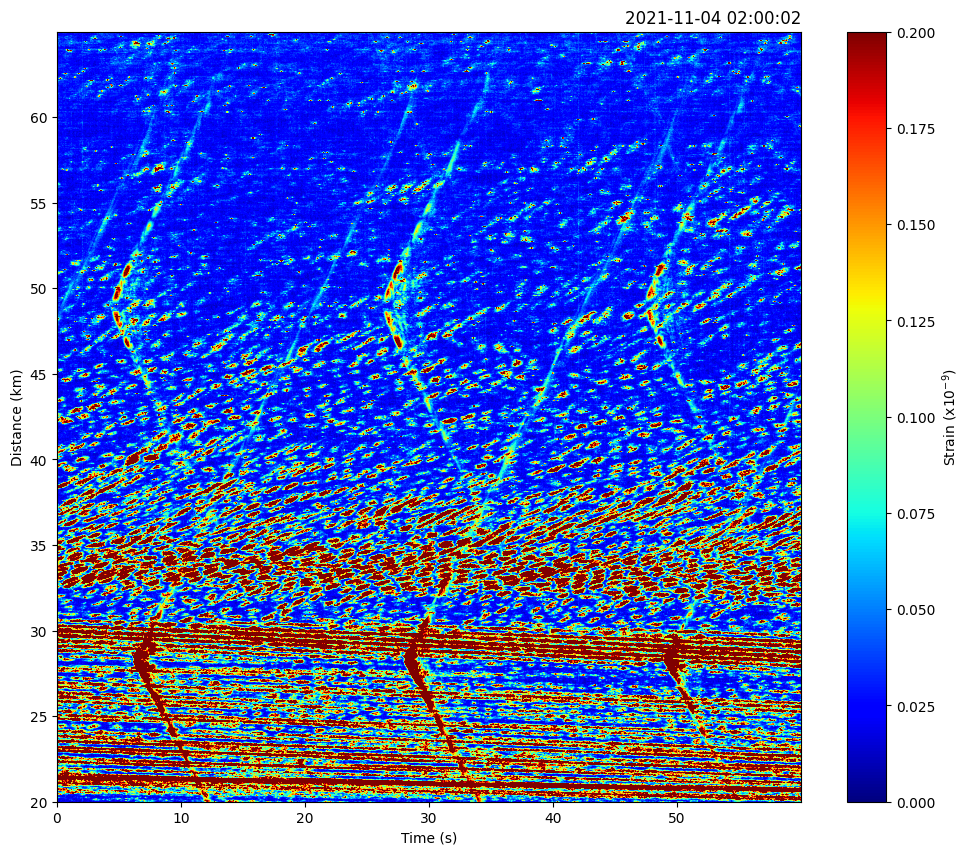

In [8]:
# band-pass filter
trf = sp.sosfiltfilt(sos_bpfilter, tr, axis=1)

# Plot
dw.plot.plot_tx(trf, time, dist, fileBeginTimeUTC, fig_size=(12, 10), v_min=0, v_max=0.2)

The spatio-temporal plot (t-x plot) shows temporal variations of the strain along the fiber optic cable between 20 and 65 km, every 8.17 m corresponding to the selected channels. We observe signals emitted by ponctual sources and propagating close to the underwater soundspeed, with apexes (minimum distance between the source and the fiber optic cable) around 27 km and 49 km and possibly another one out of the range of the analysis. These sounds show the temporal regularity of fin whales song. The noise is also strong closer to shore <40 km. 

### Filtering in the frequency-wavenumber domain (f-k) and corresponding t-x plot

The spatio-temporal DAS strain data is transformed in the frequency-wavenumber (f-k) domain by applying a 2D FFT. There, it is possible to apply a fan filter to select only certain speeds and then, go back to the time domain. This process is available using successively:
* `das4whales.dsp.fk_filter_design(params)`, that creates the filter
* `das4whales.dsp.fk_filter_filt(params)`, that transforms the data to the f-k domain, applies the filter and transforms the data back to the t-x domain

In [9]:
# Create the f-k filter
fk_filter = dw.dsp.fk_filter_design((trf.shape[0],trf.shape[1]), selected_channels, dx, fs, 
                                    cs_min=1400, cp_min=1480, cp_max=3400, cs_max=3500)

# Apply the f-k filter to the data, returns spatio-temporal strain matrix
trf_fk = dw.dsp.fk_filter_filt(trf, fk_filter)

# Plot
dw.plot.plot_tx(trf_fk, time, dist, fileBeginTimeUTC, fig_size=(12, 10), v_min=0, v_max=0.2)

AttributeError: 'numpy.ndarray' object has no attribute 'toarray'

### Spatio-spectral representation 

Different features are considered to identify the calling species such as the rhythmic or inter-call intervals, the intensity or received levels, the contours in the time-frequency domain. However, the decisive characteristics to classify baleen whales is the spectral content of the signal. We therefore propose a spatio-spectral representation of the DAS recordings or f-x plot to show the spectral signature and its evolution against the distance.

In the following example, the a FFT is applied to each channel of 2-s clips of the spatio-temporal das data. The clip duration is specified by the parameter `win_s`

In [ ]:
# Spatio-spectral plot
dw.plot.plot_fx(trf_fk, dist, fs, file_begin_time_utc=fileBeginTimeUTC, win_s=2,
                nfft=512,  f_min=10, f_max=35, fig_size=(25, 10), 
                v_min = 0, v_max = 0.1)

## Select channel and display its spectrogram and associated audio

In [ ]:
from IPython.display import Audio

# read one channel only as audio
selected_chan = 27000 # (m)
idx = (np.abs(dist - selected_chan)).argmin()

# Spectrogram
p,tt,ff = dw.dsp.get_spectrogram(trf_fk[idx,:], fs, nfft=128, overlap_pct=0.8)
dw.plot.plot_spectrogram(p, tt,ff, f_min = 0, f_max = 50, v_min=0)
Audio(data=trf_fk[idx,:], rate=fs*5)


In [ ]:

# read one channel only as audio
selected_chan = 50000 # (m)
idx = (np.abs(dist - selected_chan)).argmin()

# Spectrogram
p,tt,ff = dw.dsp.get_spectrogram(trf_fk[idx,:], fs, nfft=128, overlap_pct=0.8)
dw.plot.plot_spectrogram(p, tt,ff, f_min = 0, f_max = 50, v_min=0)
Audio(data=trf_fk[idx,:], rate=fs*5)
